In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import *

from qiskit_aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
sim = AerSimulator()

from util import zero, one, Pretty

# QI: Mixed States and Density Matrices

In this notebook, we'll introduce **density matrices**. Density matrices enable us to describe **mixed states** which are statical ensembles of quantum states. Mixed states can arise due to **decoherence**/noise or due to partial measurement. 

1. [Quantum Computation and Quantum Information: Chapter 2.4, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)
2. [https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html](https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html)

## Mixed States

A collection

$$
\{ (p_1, |v_1\rangle), \dots, (p_n, |v_n\rangle) \}
$$

where $|v_i\rangle$ are quantum state vectors and $\sum_{i=1}^n p_i = 1$ is a **mixed state**. We can interpret a mixed state as a classic probability distribution over quantum state vectors. Thus we can also call a mixed state an **ensemble**.

### Examples

We'll unpack the definition with a few examples.

#### Example 1

We'll first look at a mixed state over a single qubit system to contrast an ensemble and superposition.

In [2]:
X1 = [zero, one]
ps1 = [0.5, 0.5]
ensemble1 = [(p, x) for p, x in zip(ps1, X1)]
ensemble1

[(0.5,
  Statevector([1.+0.j, 0.+0.j],
              dims=(2,))),
 (0.5,
  Statevector([0.+0.j, 1.+0.j],
              dims=(2,)))]

Text(0.5, 1.0, 'Ensemble 1')

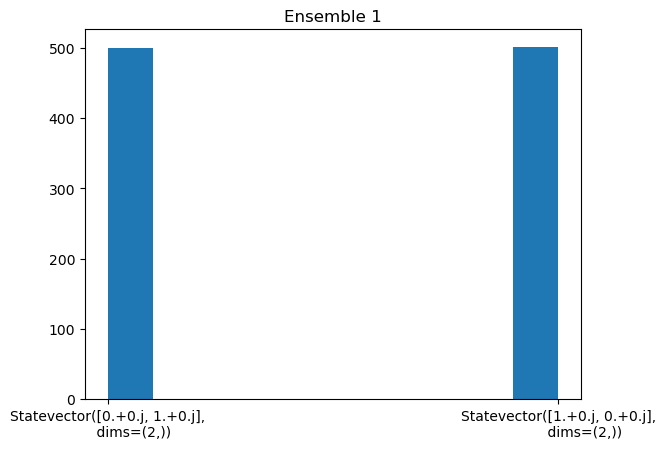

In [3]:
samples = random.choices(
    [str(x) for p, x in ensemble1],
    weights=[p for p, x in ensemble1],
    k=1000
)
plt.hist(samples); plt.title("Ensemble 1")

1. The mixed state given by ensemble 1 is either $|0\rangle$ or $|1\rangle$ with 50% probability.
2. The mixed state is different from the state $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ that is an equal superposition of $|0\rangle$ and $|1\rangle$ with 100% probability.
3. Upon measurement, we still obtain that $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ gives either $|0\rangle$ or $|1\rangle$ with 50% probability.

#### Example 2

Our next example looks at a mixed state over a single qubit involving 3 components.

In [4]:
# Can overspecify
X2 = [zero, one, 1/np.sqrt(2)*zero + 1/np.sqrt(2)*one]
ps2 = [0.2, 0.5, 0.3]
ensemble2 = [(p, x) for p, x in zip(ps2, X2)]
ensemble2

[(0.2,
  Statevector([1.+0.j, 0.+0.j],
              dims=(2,))),
 (0.5,
  Statevector([0.+0.j, 1.+0.j],
              dims=(2,))),
 (0.3,
  Statevector([0.70710678+0.j, 0.70710678+0.j],
              dims=(2,)))]

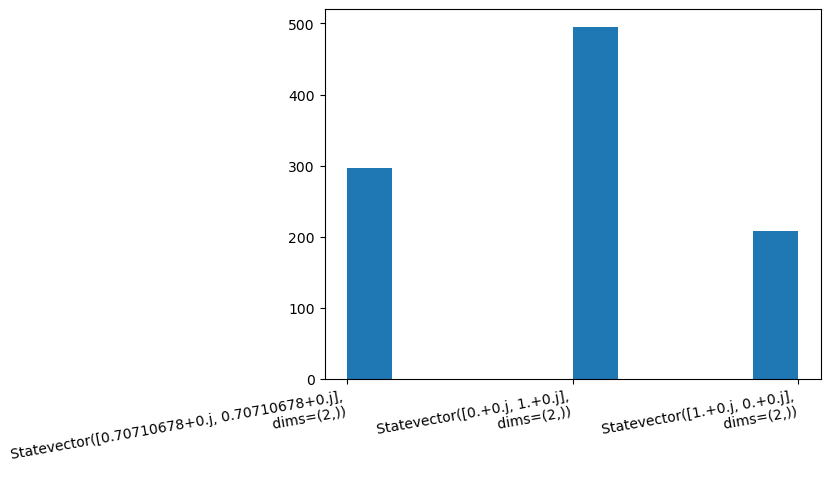

In [5]:
samples = random.choices(
    [str(x) for p, x in ensemble2],
    weights=[p for p, x in ensemble2],
    k=1000
)
fig, axes = plt.subplots(1, 1); plt.hist(samples)
plt.setp(axes.get_xticklabels(), rotation=10, horizontalalignment='right');

1. The mixed state given by ensemble 2 is either $|0\rangle$ (30%), $|1\rangle$ (50%), or $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ (20%).
2. Upon measurement, we obtain $|0\rangle$ with probability 35% and $|1\rangle$ with 65% probability.

#### Example 3

Our final example introduces one over a multi-qubit system.

In [6]:
# Can underspecify (missing one ^ zero)
X3 = [zero ^ zero, one ^ one, zero ^ one]
ps3 = [0.3, 0.2, 0.5]
ensemble3 = [(p, x) for p, x in zip(ps3, X3)]
ensemble3

[(0.3,
  Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
              dims=(2, 2))),
 (0.2,
  Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
              dims=(2, 2))),
 (0.5,
  Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
              dims=(2, 2)))]

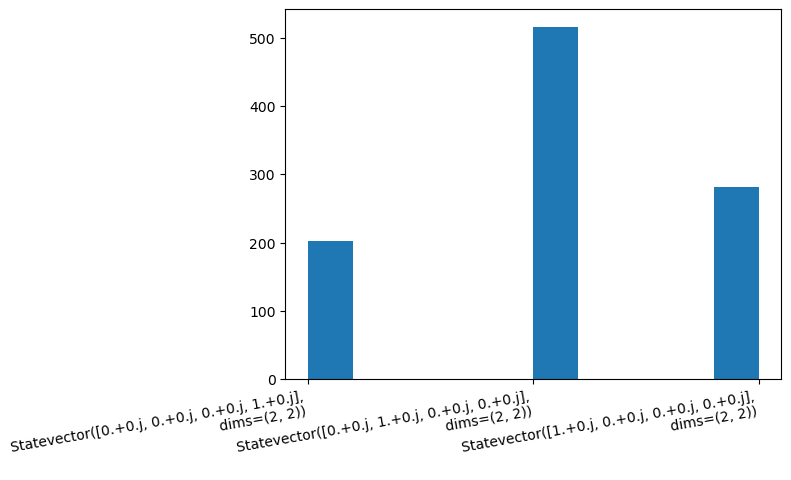

In [7]:
samples = random.choices(
    [str(x) for p, x in ensemble3],
    weights=[p for p, x in ensemble3],
    k=1000
)
fig, axes = plt.subplots(1, 1); plt.hist(samples)
plt.setp(axes.get_xticklabels(), rotation=10, horizontalalignment='right');

The mixed state given by ensemble 3 is either $|00\rangle$ (30%), $|11\rangle$ (20%), or $|01\rangle$ (50%).

### Mixed States vs. Pure States

The state of a quantum system given by an ordinary quantum state vector is called a **pure state**.

## Motiviating Mixed States

Mixed states can arise due to **decoherence**/noise or due to partial measurement.

### Situation 1: Decoherence/Noise

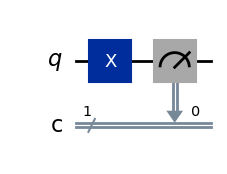

In [8]:
qc = QuantumCircuit(1, 1)
if np.random.rand() < 0.5:  # Suppose our hardware is faulty/noisy
    qc.x(0) # 50% of the time, we flip
else:
    qc.id(0) # 50% of the time, we don't do anything
qc.measure(0, 0)
qc.draw(output="mpl", style="iqp")

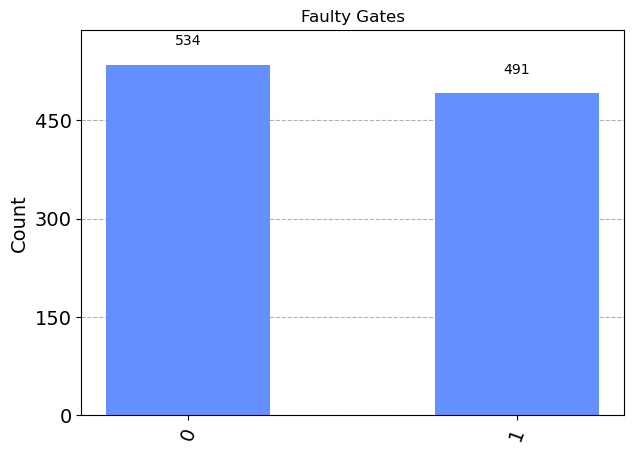

In [9]:
counts = {'0': 0, '1': 1}
for i in range(1024):
    qc = QuantumCircuit(1, 1)
    if np.random.rand() < 0.5:
        qc.x(0)
    else:
        qc.id(0)
    qc.measure(0, 0)
    state = sim.run(qc, shots=1).result()
    for k, v in state.get_counts().items():
        counts[k] += v
plot_histogram(counts, title='Faulty Gates')

### Situation 2: Partial Measurement

Consider the following entangled state.

In [10]:
entangled = 1/np.sqrt(2)*(zero ^ zero) + 1/np.sqrt(2)*(one ^ one)
entangled.draw("latex")

<IPython.core.display.Latex object>

#### Question

What can we say about the state of qubit 0 if we only measure qubit 1?

#### Answer

Let's reason through this by running an experiment.

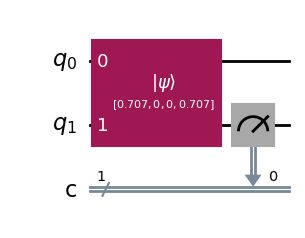

In [11]:
# Step 1: Prepare a measurement circuit
qc = QuantumCircuit(2, 1)
qc.initialize(entangled)
qc.measure(1, 0)
qc.draw(output="mpl", style="iqp")

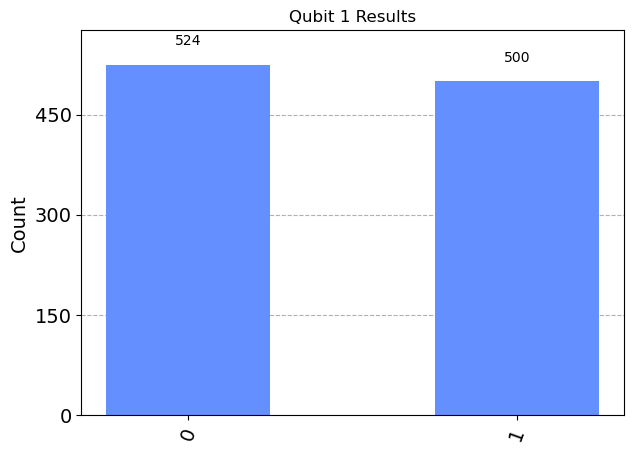

In [12]:
# Step 2: Perform the measurement
state = sim.run(qc, shots=1024).result()
plot_histogram(state.get_counts(), title='Qubit 1 Results')

#### Analysis

1. After running the experiment, we see that qubit 1 is $|0\rangle$ 50% of the time and $|1\rangle$ 50% of the time.
2. Moreover, our 2-qubit system was entangled
$$
\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle \,.
$$
3. If qubit 0 is $|0\rangle$, then qubit 1 is $|0\rangle$. Similarly, if qubit 0 is $|1\rangle$, then qubit 0 is $|0\rangle$.
4. However, measurement forces us to observe either $|0\rangle$ or $|1\rangle$ for qubit 1 with some probability, which by entanglement, forces this probability onto qubit $0$.
5. We have recreated the mixed state given by ensemble 1!

## Density Matrix

A **density matrix** provides an alternative characterization of mixed states and generalizes the notion of a quantum state vector.

### Definition

Let $\{ (p_1, |v_1\rangle), \dots, (p_n, |v_n\rangle) \}$ be an ensemble. A **density matrix** $\rho$ is defined as

$$
\rho = \sum_{i=1}^n p_i |v_i\rangle \langle v_i|
$$

where $|v_i\rangle \langle v_i|$ is an **outer product**.

#### Aside: Outer Product

\begin{align*}
|x\rangle \langle y| & = \begin{pmatrix}
x_1 \\
\vdots \\
x_n
\end{pmatrix} \begin{pmatrix}
\overline{y_1} & \dots & \overline{y_m}
\end{pmatrix} \tag{bra/ket} \\
& = \begin{pmatrix} 
x_1\overline{y_1} & \dots & x_1 \overline{y_m} \\
\vdots & \ddots & \vdots \\
x_n\overline{y_1} & \dots & x_n \overline{y_m} \\
\end{pmatrix} \tag{matrix multiplication}
\end{align*}

In [13]:
Pretty(np.outer(np.array([1+1j, 1-1j, 2j]), np.array([1+1j, 1-1j])))

<IPython.core.display.Latex object>

In [14]:
def ensembleToDensmat(ensemble: list[Tuple[float, Statevector]]) -> qi.DensityMatrix:
    return qi.DensityMatrix(sum([p * np.outer(x, x) for (p, x) in ensemble]))

### Examples

In [15]:
ensemble1

[(0.5,
  Statevector([1.+0.j, 0.+0.j],
              dims=(2,))),
 (0.5,
  Statevector([0.+0.j, 1.+0.j],
              dims=(2,)))]

In [16]:
rho1 = ensembleToDensmat(ensemble1)
rho1.draw("latex")

<IPython.core.display.Latex object>

In [17]:
X15 = [1/np.sqrt(2) * zero + 1/np.sqrt(2)*one]
ps15 = [1.0]
ensemble15 = [(p, x) for p, x in zip(ps15, X15)]
rho15 = ensembleToDensmat(ensemble15)
rho15.draw("latex")

<IPython.core.display.Latex object>

In [18]:
ensemble2

[(0.2,
  Statevector([1.+0.j, 0.+0.j],
              dims=(2,))),
 (0.5,
  Statevector([0.+0.j, 1.+0.j],
              dims=(2,))),
 (0.3,
  Statevector([0.70710678+0.j, 0.70710678+0.j],
              dims=(2,)))]

In [19]:
rho2 = ensembleToDensmat(ensemble2)
Pretty(rho2)

<IPython.core.display.Latex object>

In [20]:
ensemble3

[(0.3,
  Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
              dims=(2, 2))),
 (0.2,
  Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
              dims=(2, 2))),
 (0.5,
  Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
              dims=(2, 2)))]

In [21]:
rho3 = ensembleToDensmat(ensemble3)
rho3.draw("latex")

<IPython.core.display.Latex object>

### Observation 1: Sum of the diagonal is always 1

In [22]:
sum(np.diag(rho1)), sum(np.diag(rho2)), sum(np.diag(rho3))

((1+0j), (0.9999999999999999+0j), (1+0j))

#### Aside: Trace

Let

$$
X = \begin{pmatrix}
X_{11} & \dots & X_{1n} \\
\vdots & \ddots & \vdots \\
X_{n1} & \dots & X_{nn} \\
\end{pmatrix}
$$

be a square matrix.

Then

$$
Tr(X) = \sum_{i=1}^n X_{ii}
$$

is the **trace** of a matrix.

In [23]:
np.trace(np.array([[1.0, 0.2], [0.3, 1.0]]))

2.0

In [24]:
np.trace(rho1), np.trace(rho2), np.trace(rho3)

((1+0j), (0.9999999999999999+0j), (1+0j))

#### Observation 1 more formally

Let $\text{diag}$ obtain the diagonal of a matrix. Then

\begin{align*}
Tr(\rho) & = Tr(\sum_{i=1}^n p_i \text{diag}(|v_i\rangle \langle v_i|)) \tag{definition} \\
& = \sum_{i=1}^n p_i Tr(|v_i\rangle \langle v_i|) \tag{trace properties} \\
& = \sum_{i=1}^n p_i (\sum_{j=1} v_{ij}\overline{v_{ij}}) \tag{outer product diagonal} \\
& = \sum_{i=1}^n p_i \tag{$\lVert v_i \rVert^2 = 1$} \\
& = 1 \tag{ensemble} \\
\end{align*}

### Observation 2: Density matrix is Hermitian

Every density matrix is a **Hermitian matrix**, i.e.,

$$
X = X^\dagger \,.
$$

In [25]:
print(np.allclose(rho1, np.conjugate(rho1).transpose()))
print(np.allclose(rho2, np.conjugate(rho2).transpose()))
print(np.allclose(rho3, np.conjugate(rho3).transpose()))

True
True
True


#### Observation 2 more formally

1. Recall

\begin{align*}
|x\rangle \langle x| & = \begin{pmatrix} 
x_1\overline{x_1} & \dots & x_1 \overline{x_n} \\
\vdots & \ddots & \vdots \\
x_n\overline{x_1} & \dots & x_n \overline{x_n} \\
\end{pmatrix} \,.
\end{align*}

2. Moreover, $\overline{x_i \overline{x_j}} = \overline{x_i} x_j$.

3. Thus

\begin{align*}
\begin{pmatrix} 
x_1\overline{x_1} & \dots & x_1 \overline{x_n} \\
\vdots & \ddots & \vdots \\
x_n\overline{x_1} & \dots & x_n \overline{x_n} \\
\end{pmatrix}^\dagger & = \begin{pmatrix} 
\overline{x_1}x_1 & \dots & \overline{x_1} x_n \\
\vdots & \ddots & \vdots \\
\overline{x_n}x_1 & \dots & \overline{x_n} x_n \\
\end{pmatrix}^T \\
& = \begin{pmatrix} 
x_1\overline{x_1} & \dots & x_1 \overline{x_n} \\
\vdots & \ddots & \vdots \\
x_n\overline{x_1} & \dots & x_n \overline{x_n} \\
\end{pmatrix}
\end{align*}

### Observation 3: Non-zero non-diagonal entries measures "quantumness"

In [26]:
# No superposition between |0> or |1>
print("Ensemble", ensemble1)
print("Purity", rho1.purity())
rho1.draw("latex")

Ensemble [(0.5, Statevector([1.+0.j, 0.+0.j],
            dims=(2,))), (0.5, Statevector([0.+0.j, 1.+0.j],
            dims=(2,)))]
Purity (0.5+0j)


<IPython.core.display.Latex object>

In [27]:
# Superposition between |0> or |1>
print("Ensemble", ensemble2)
print("Purity", rho2.purity())
rho2.draw("latex")

Ensemble [(0.2, Statevector([1.+0.j, 0.+0.j],
            dims=(2,))), (0.5, Statevector([0.+0.j, 1.+0.j],
            dims=(2,))), (0.3, Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,)))]
Purity (0.5899999999999999+0j)


<IPython.core.display.Latex object>

## Density Matrix Formulation of Quantum Computation

We reformulate quantum computation using density matrices. This includes
1. reformulating the quantum state representation,
2. unitary evolution, and
3. measurement.

### Quantum State Representation

Every quantum state vector $|v\rangle$ maps to the ensemble $\{(1, |v\rangle)\}$

In [28]:
v = 1/np.sqrt(2)*zero + 1/np.sqrt(2)*one
v.draw("latex")

<IPython.core.display.Latex object>

In [29]:
qi.DensityMatrix(v).draw("latex")

<IPython.core.display.Latex object>

### Unitary Evolution

The equivalent evolution of a density matrix $\rho_{start} = |\psi\rangle \langle \psi|$ by $U$ is given by

$$
\rho_{final} = U \rho_{start} U^\dagger \,.
$$

#### Recall: Quantum state vector evolution

Given a quantum state vector $|\psi\rangle$ and a unitary transformation $U$, the result of applying $U$ was $U|\psi\rangle$.

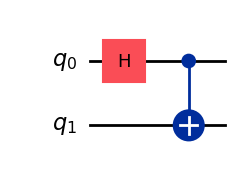

In [30]:
# Construct circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw(output="mpl", style="iqp")

In [31]:
# Corresponding unitary transformation
U = Operator(qc)
U.draw("latex")

<IPython.core.display.Latex object>

In [32]:
print("Final state calculated with unitary evolution ...")
start = zero ^ zero
final = start.evolve(U)
final.draw("latex")

Final state calculated with unitary evolution ...


<IPython.core.display.Latex object>

In [33]:
print("Final density matrix calculated with density matrix evolution ...")
qi.DensityMatrix(start).evolve(U).draw("latex")

Final density matrix calculated with density matrix evolution ...


<IPython.core.display.Latex object>

In [34]:
print("Do unitary evolution and density matrix evolution match?", np.allclose(qi.DensityMatrix(start).evolve(U), qi.DensityMatrix(final)))

Do unitary evolution and density matrix evolution match? True


### Measurement


1. Let $\{ \Pi_m \}_m$ be a complete set of **measurement operators** where $m$ refers to the outcome so that it satisfies

$$
\sum_m \Pi_m^\dagger \Pi_m = I \,.
$$

2. Then the probability of obtaining outcome $m$ after measuring is

$$
p(m) = tr(\Pi_m^\dagger \Pi_m \rho) \,.
$$

3. The state of the system after measurement is

$$
\frac{\Pi_m \rho \Pi_m^\dagger}{tr(\Pi_m^\dagger \Pi_m \rho)} \,.
$$

In [35]:
def measure_outcome(rho: qi.DensityMatrix, M_m: np.ndarray) -> Tuple[float, qi.DensityMatrix]:
    # Probability of measuring m
    p_m = np.trace(np.conjugate(M_m.transpose()) @ M_m @ rho.data)

    # Resulting state after m
    rho_p = (M_m @ rho.data @ np.conjugate(M_m.transpose())) / p_m
    
    return p_m, rho_p

#### Example: Bell State

We'll check that the reformulation of measurement matches on the Bell state.
First, we recall the entangling circuit that created the Bell state.

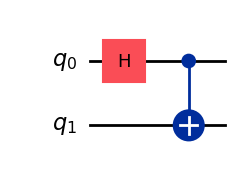

In [36]:
qc.draw(output="mpl", style="iqp")

In [37]:
(zero ^ zero).evolve(qc).draw("latex")

<IPython.core.display.Latex object>

In [38]:
rho = qi.DensityMatrix(qc)
rho.draw("latex")

<IPython.core.display.Latex object>

Recall that our measurement operators for partially measuring the first qubit ($|q_0\rangle$) were
1. $\Pi_{*0} = |00\rangle\langle 00| + |10\rangle\langle 10|$ and
2. $\Pi_{*1} = |01\rangle\langle 01| + |11\rangle\langle 11|$.

In [39]:
zz = zero ^ zero; zo = zero ^ one; oz = one ^ zero; oo = one ^ one
Pi0s = np.outer(zz, zz) + np.outer(oz, oz) # Pi0s only observes 1st qubit, and we get 0
Pi1s = np.outer(zo, zo) + np.outer(oo, oo) # Pi1s only observes 1st qubit, and we get 1
Pretty(Pi0s + Pi1s)

<IPython.core.display.Latex object>

We'll check the result of measuring $|q_0\rangle$ and obtaining $0$.

In [40]:
p_0, rho_0 = measure_outcome(rho, Pi0s)
print("probability |0>", p_0)
print("resulting density matrix")
# Note that we can express measurement of partial states
Pretty(rho_0)

probability |0> (0.4999999999999999+0j)
resulting density matrix


<IPython.core.display.Latex object>

Similarly, we'll check the result of measuring $|q_0\rangle$ and obtaining $1$.

In [41]:
p_1, rho_1 = measure_outcome(rho, Pi1s)
print("probability |1>", p_1)
print("resulting density matrix")
# Note that we can express measurement of partial states
Pretty(rho_1)

probability |1> (0.4999999999999999+0j)
resulting density matrix


<IPython.core.display.Latex object>

## Summary

1. Introduced mixed states and density matrices, which are fundamental abstractions in QIS.
2. We Reformulated the unitary evolution of quantum states in terms of density matrices.